# Увеличение прибыльности торговой стратегии

Цель: увеличить годовую прибыльность торговой стратегии на бирже акций.

Задача: найти гиперпараметры торговой стратегии на бирже, при которых годовой доход будет максимальным.

Проблема: У торговой стратегии есть множество настраиваемых параметров, от которых напрямую зависит доходность. Количество сочетаний параметров - более триллиона. Из-за ограничения вычислительных мощностей из этого триллиона удаётся проверить за день только 20 тысяч значений доходности в режиме симуляции торгов.

Решение проблемы заключается в создании модели машинного обучения на основе нейронных сетей, которая способна предсказывать доходность стратегии по заданным параметрам. Используя эту модель можно значительно ускорить поиск прибыльной стратегии.

In [1]:
# http://epistasislab.github.io/tpot/examples/
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from trigger import get_path
from glob import glob
from tools import pd_read_csv, pd_to_csv, df_reduce_mem_usage
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ast
import pickle
from multiprocessing import cpu_count
from sklearn.model_selection import train_test_split
import joblib
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings(action='ignore')
plt.style.use('dark_background') 

In [2]:
def do_one_hot(df, object_features): 
    return pd.get_dummies(df, columns=object_features)

def plot_pred(x_train, y_train, x_picked, y_picked):
    # color='green', marker='o', linestyle='dashed', linewidth=2, markersize=12
    fig = plt.figure(1, figsize=(8, 5), dpi=80)
    real = list(range(int(min(x_train)), 1+round(max(x_train))))
    plt.scatter(x_train, y_train, color='r', s=1.4, label='Значения из обучающей выборки') # , label='Текущее предсказание'
    plt.plot(x_picked, y_picked, color='w', linewidth=1, linestyle='-', label='Новые неизвестные значения', alpha=0.8) # , label='Неизвестные для модели значения'
    plt.plot(real, real, linestyle='--', label='Идеальное предсказание')
    plt.xlabel("Практическая доходность, %")
    plt.ylabel("Предсказанная доходность, %")
    plt.legend(loc='upper left')
    plt.grid(which='minor', alpha=0.3)
    plt.grid(which='major', alpha=0.33)
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
    plt.axvline(x=0, color='r', linestyle='--', alpha=0.3)
    plt.grid(True)
    plt.show()
    
# def predict(params, columns, model, object_features):
#     df_to_predict = pd.DataFrame([params])
#     df_to_predict = do_one_hot(df_to_predict, object_features)
    
#     for col in columns:
#         if col not in df_to_predict.columns:
#             df_to_predict[col] = False
    
#     return model.predict(df_to_predict[columns].fillna(False))[0]
    
def param_to_dict(row):
    """Преобразует строку параметров в словарь"""
    dict_params = {}
    pairs = row.split('&')
    for pair in pairs:
        k, v = pair.split('=')
        dict_params[k] = parce_str_into_list_int_float(v)
        
    return dict_params
    
def parce_str_into_list_int_float(val):
    """Парсит строку в список, int или float"""
    str_val = str(val)

    can_eval = False
    if '[' in str_val and ']' in str_val: # list
        can_eval = True
    elif str_val.replace('.', '', 1).isdigit(): # int, float
        can_eval = True

    return ast.literal_eval(val) if can_eval else val

# folder_csv = 'data/simulator/all_balance_parts'
# folder_model = 'data/ml/parts_90_10'
# df = pd.concat((
#     pd_read_csv(f'{folder}/result-stage-3.csv'),
#     pd_read_csv(f'{folder}/result-stage-2.csv'),
#     pd_read_csv(f'{folder}/result-all.csv'),
#     pd_read_csv(f'{folder}/result-all-2.csv'),
#     pd_read_csv(f'{folder}/result_best_proba.csv'),
#     pd_read_csv(f'{folder}/result-best.csv'),
# ))

folder_csv = 'data/simulator/parts_90_10'
folder_model = 'data/ml/parts_90_10'
df = pd.concat((
     # pd_read_csv(get_path('simulator_result'), parts='append'),
     pd_read_csv('data/simulator/90_10/result22+.csv', parts='append'),
     pd_read_csv('data/simulator/90_10/result30+.csv', parts='append'),
     pd_read_csv('data/simulator/90_10/result.csv', parts='append')
))

df.reset_index(drop=True, inplace=True)
df['STRATEGY_PARAM'] = df['STRATEGY_PARAM'].apply(param_to_dict)

df = pd.concat((df[['PRC_YEAR_AVG', 'SIM_BALANCE_PARTS']], # 'SUCCESS_PRC', 
                pd.DataFrame(df['STRATEGY_PARAM'].values.tolist())), axis=1)


# df.sample(frac=1) # перемешиваем
# df.sort_values('PRC_YEAR_AVG', ascending=False, inplace=True) # сортировка по убыванию доходности
# df = df.iloc[:20000] # ограничили кол-во

df.sort_values('PRC_YEAR_AVG', ascending=False, inplace=True)
df.reset_index(drop=True, inplace=True)

df_picked_features = df[df.index % 10 == 0] # лучшие для проверки способности предсказывать выше ожидаемого
df_picked_target = df_picked_features['PRC_YEAR_AVG']

df_train_features = df[df.index % 10 != 0].sample(frac=1) # Перемешиваем заранее (этого требуют некоторые AutoML алгоритмы)
df_train_target = df_train_features['PRC_YEAR_AVG']

object_features = [
    # object
    'ema_order',
    'macd_sign',
    'macd_signal_sign',
    'macd_hist_sign',
    # 'soft_take_profit',
    # 'before_below_prc',
    # 'SIM_BALANCE_PARTS',
]

columns_features = [
    # int
    'index_len',
    'limit_min',
    'limit_max',
    'tick_limit_prolong',
    'rsi_min',
    'rsi_max',
    'rsi_len',
    
    # float
    'stop_loss',
    'take_profit_prc',
    # 'ema_200_spread_min',
    # 'ema_200_spread_max',
    # 'soft_take_profit_factor',
    # 'before_below_prc_factor',
] + object_features

df_train_features = do_one_hot(df_train_features[columns_features], object_features)
df_picked_features = do_one_hot(df_picked_features[columns_features], object_features)
for col in df_train_features.columns: # после one-hot раззделения колонки должны совпадать
    if col not in df_picked_features.columns:
        df_picked_features[col] = False

assert set(df_train_features.columns) == set(df_picked_features.columns), 'Колонки не совпадают!'

print(f'Кол-во событий: {df_train_features.shape[0]}, ')
print(f'кол-во параметров: {df_train_features.shape[1]}, ')
print(f'кол-во событий для независимого тестирования: {df_picked_features.shape[1]}')

Кол-во событий: 3018, 
кол-во параметров: 21, 
кол-во событий для независимого тестирования: 21


# autokeras

In [3]:
# Перед установкой обязательно: pip install --upgrade pip --break-system-packages
# pip install autokeras tensorflow --break-system-packages

# Если при выполнении ошибка 'keras_tuner.engine' has no attribute 'tuner', то в 
# файле ~/.local/lib/python3.11/site-packages/autokeras/engine/tuner.py
# заменить все вхождения keras_tuner.engine.tuner на keras_tuner.Tuner
# на 30 строке поставить: "class AutoTuner(keras_tuner.Tuner):"
# на 65 строке поставить: "keras_tuner.engine.tuner"

In [3]:
import tensorflow as tf
import autokeras as ak
from tensorflow.keras.models import load_model as tf_load_model

Using TensorFlow backend


In [5]:
# Initialize the structured data regressor.
reg = ak.StructuredDataRegressor(
    directory=f'{folder_model}/autokeras_StructuredDataRegressor',
    overwrite=True,
    seed=42,
    # max_trials=3,
)
# Feed the structured data regressor with training data.
df_for_autokeras = tf.data.Dataset.from_tensor_slices((df_train_features.astype(float), 
                                                       df_train_target.astype(float)))
reg.fit(
    df_for_autokeras,
    # x=df_train_features.astype(float),
    # y=df_train_target.astype(float),
    validation_split=0.25,
    # epochs=1000,
    verbose=1,
)
model_autokeras = reg.export_model()

Trial 100 Complete [00h 00m 49s]
val_loss: 65.87665557861328

Best val_loss So Far: 62.02037811279297
Total elapsed time: 02h 01m 51s
Epoch 1/53
95/95 [==============================] - 2s 6ms/step - loss: 187.8056 - mean_squared_error: 187.8056
Epoch 2/53
95/95 [==============================] - 1s 6ms/step - loss: 111.6639 - mean_squared_error: 111.6639
Epoch 3/53
95/95 [==============================] - 1s 6ms/step - loss: 93.9321 - mean_squared_error: 93.9321
Epoch 4/53
95/95 [==============================] - 1s 6ms/step - loss: 86.5636 - mean_squared_error: 86.5636
Epoch 5/53
95/95 [==============================] - 1s 6ms/step - loss: 85.1343 - mean_squared_error: 85.1343
Epoch 6/53
95/95 [==============================] - 1s 6ms/step - loss: 85.7934 - mean_squared_error: 85.7934
Epoch 7/53
95/95 [==============================] - 1s 6ms/step - loss: 82.2951 - mean_squared_error: 82.2951
Epoch 8/53
95/95 [==============================] - 1s 6ms/step - loss: 81.3363 - mean_squar

In [7]:
# Сохраняем модель
model_file = f'{folder_model}/autokeras_model'
model_autokeras.save(f"{model_file}", save_format="tf")

# Сохраняем модель в файл pickle
# with open(model_file+'-pickle', 'wb') as f:
#     pickle.dump(model_autokeras, f)

2023-10-06 14:25:18,123 tensorflow INFO - Assets written to: data/ml/parts_90_10/autokeras_model/assets


In [25]:
# грузим модель из файла
model_file = f'{folder_model}/autokeras_model'
model_autokeras = tf_load_model(model_file)
# грузим модель из файла pickle
# model_autokeras_pkl = None
# with open(model_file+'-pickle', 'rb') as f:
#     model_autokeras_pkl = pickle.load(f)

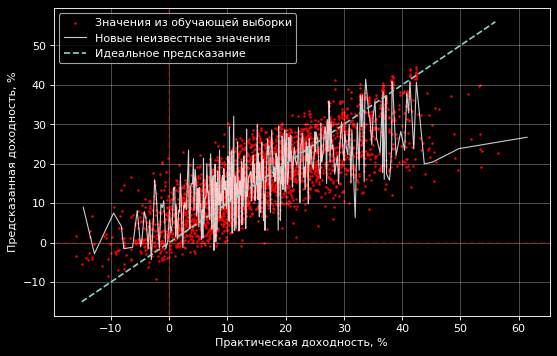

In [26]:
# тренировочные
y_train = model_autokeras.predict(df_train_features.astype(float), verbose=0)
x_train = df_train_target.to_list()

# тестовые которые не вошли в выборку
y_picked = model_autokeras.predict(df_picked_features.astype(float), verbose=0)
x_picked = df_picked_target.to_list()

plot_pred(x_train, y_train, x_picked, y_picked)

In [27]:
# добавляем колонку с предсказаниями предыдущей модели
df_picked_target
df_train_target
df_picked_features['autokeras_stage_pre_predict'] = y_picked
df_train_features['autokeras_stage_pre_predict'] = y_train

# tpot

In [10]:
# pip install numpy scipy scikit-learn pandas joblib torch tpot ipywidgets --break-system-packages

In [7]:
from tpot import TPOTRegressor

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df_train_features,
                                                    df_train_target,
                                                    train_size=0.75,
                                                    test_size=0.25,
                                                    random_state=42) 

model_tpot = TPOTRegressor(# generations=15,
                           # population_size=5,
                           early_stop=15,
                           verbosity=2,
                           random_state=42,
                           n_jobs=-1)

model_tpot.fit(X_train, y_train)

Optimization Progress:   0%|          | 0/10100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -52.0047921922923

Generation 2 - Current best internal CV score: -52.0047921922923

Generation 3 - Current best internal CV score: -52.0047921922923

Generation 4 - Current best internal CV score: -52.0047921922923

Generation 5 - Current best internal CV score: -52.0047921922923

Generation 6 - Current best internal CV score: -52.0047921922923

The optimized pipeline was not improved after evaluating 5 more generations. Will end the optimization process.

TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: GradientBoostingRegressor(input_matrix, alpha=0.95, learning_rate=0.1, loss=huber, max_depth=10, max_features=0.5, min_samples_leaf=17, min_samples_split=6, n_estimators=100, subsample=0.9000000000000001)


TPOTRegressor(early_stop=5, n_jobs=-1, random_state=42, verbosity=2)

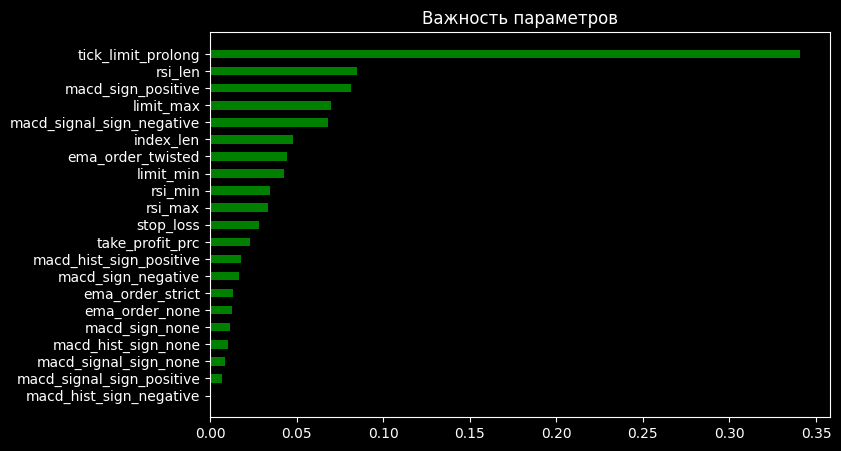

In [27]:
# Важность параметров модели
exctracted_best_model = model_tpot.fitted_pipeline_.steps[-1][1] # model_tpot.fitted_pipeline_
exctracted_best_model.fit(df_train_features, df_train_target)
positions = range(exctracted_best_model.feature_importances_.shape[0])
# plt.barh(positions, exctracted_best_model.feature_importances_)
# plt.yticks(df_train_features.columns.to_list())
res = dict(zip(df_train_features.columns, exctracted_best_model.feature_importances_))
res = dict(sorted(res.items(), key=lambda x: x[1], reverse=True))

fig, ax = plt.subplots(figsize=(8, 5))
ax.barh(list(res.keys()),
        list(res.values()),
        align='center',
        color='green',
        ecolor='black',
        height=0.5)
ax.set_yticks(positions)
ax.set_yticklabels(list(res.keys()))
ax.invert_yaxis()
ax.set_title('Важность параметров')
plt.show()

In [9]:
model_file = f'{folder_model}/tpot_model.joblib'
# Сохраняем модель
joblib.dump(model_tpot.fitted_pipeline_, model_file)

['data/ml/parts_90_10/tpot_model.joblib']

In [17]:
model_file = f'{folder_model}/tpot_model.joblib'
# грузим модель из файла
model_tpot = joblib.load(model_file)

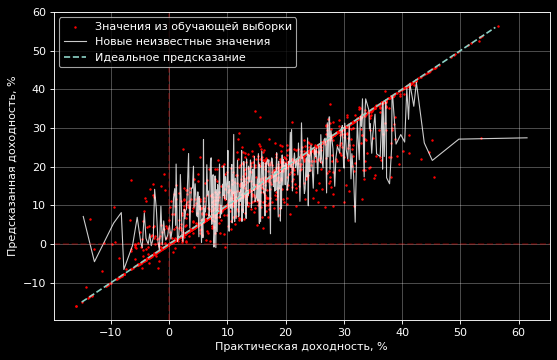

In [13]:
# тренировочные
y_train = model_tpot.predict(df_train_features)
x_train = df_train_target.to_list()

# тестовые которые не вошли в выборку
y_picked = model_tpot.predict(df_picked_features)
x_picked = df_picked_target.to_list()

plot_pred(x_train, y_train, x_picked, y_picked)

In [12]:
# добавляем колонку с предсказаниями предыдущей модели
df_picked_target
df_train_target
df_picked_features['tpot_stage_pre_predict'] = y_picked
df_train_features['tpot_stage_pre_predict'] = y_train

# flaml

In [13]:
# pip install flaml --break-system-packages

In [14]:
# добавляем колонку с предсказаниями предыдущей модели
df_picked_target
df_train_target
df_picked_features['flaml_stage_pre_predict'] = y_picked
df_train_features['flaml_stage_pre_predict'] = y_train

In [15]:
from flaml import AutoML

automl_settings = {
    # "time_budget": 1,
    "metric": 'r2',
    "task": 'regression',
    # "log_file_name": "california.log",
    "estimator_list": ['xgboost'],  # list of ML learners; we tune lightgbm in this example
    "seed": 42,  # random seed
}
model_flaml = AutoML()
model_flaml.fit(X_train=df_train_features, 
                y_train=df_train_target, 
                **automl_settings)

[flaml.automl.logger: 10-03 17:24:39] {1679} INFO - task = regression
[flaml.automl.logger: 10-03 17:24:39] {1690} INFO - Evaluation method: cv
[flaml.automl.logger: 10-03 17:24:39] {1788} INFO - Minimizing error metric: 1-r2
[flaml.automl.logger: 10-03 17:24:39] {1811} WARNING - No search budget is provided via time_budget or max_iter. Training only one model per estimator. Zero-shot AutoML is used for certain tasks and estimators. To tune hyperparameters for each estimator, please provide budget either via time_budget or max_iter.
2023-10-03 17:24:39,081 flaml.default.suggest INFO - metafeature distance: 3.2004906706149012
2023-10-03 17:24:39,084 flaml.default.suggest INFO - metafeature distance: 0.9419935111936325
[flaml.automl.logger: 10-03 17:24:39] {1900} INFO - List of ML learners in AutoML Run: ['xgboost']
[flaml.automl.logger: 10-03 17:25:18] {2627} INFO - retrain xgboost for 39.0s
[flaml.automl.logger: 10-03 17:25:18] {2630} INFO - retrained model: XGBRegressor(base_score=Non

In [16]:
# Сохраняем модель
model_file = f'{folder_model}/flaml_model'

with open(f'{model_file}.pkl', 'wb') as f:
    pickle.dump(model_flaml, f, pickle.HIGHEST_PROTOCOL)

In [17]:
# грузим модель из файла
model_flaml = None
model_file = f'{folder_model}/flaml_model'
with open(f'{model_file}.pkl', 'rb') as f:
    model_flaml = pickle.load(f)

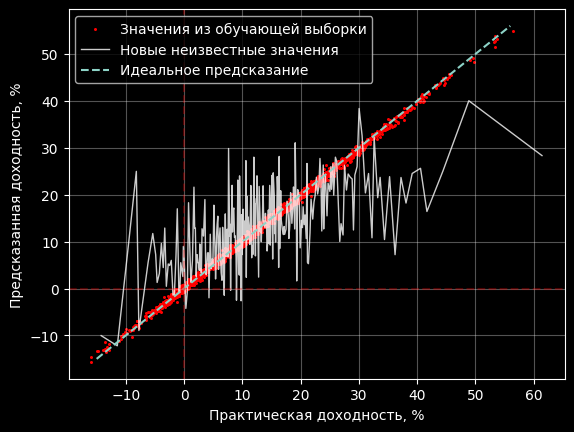

In [18]:
# тренировочные
y_train = model_flaml.predict(df_train_features)
x_train = df_train_target.to_list()

# тестовые которые не вошли в выборку
y_picked = model_flaml.predict(df_picked_features)
x_picked = df_picked_target.to_list()

plot_pred(x_train, y_train, x_picked, y_picked)

## Заключение

In [34]:
thr = 10
dd = pd.concat([df_train_features, pd.DataFrame(y_train)])
prc = round(100 * dd[ dd[0]>=thr ].shape[0] / dd.shape[0], 1)
print(f'В выборке есть всего {prc}% событий с предсказанием доходности больше {thr}%. ')
print(f'Модель явно переобучена. Но это не сильно ухудшает результаты предсказаний. ')
print(f'Использование этой модели увеличит скорость поиска '
      f'доходных параметров стратегии в {round(100/prc)} раз.')

В выборке есть всего 30.9% событий с предсказанием доходности больше 10%. 
Модель явно переобучена. Но это не сильно ухудшает результаты предсказаний. 
Использование этой модели увеличит скорость поиска доходных параметров стратегии в 3 раз.


In [12]:
df_train_features
df_train_target

# pycaret (не устанавливается, поэтому используем только autokeras и tpot)

In [ ]:
# pip install pycaret --break-system-packages # - требует слишком старых библиотек, которые несовместимы с питоном 3.11

In [ ]:
# добавляем колонку с предсказаниями предыдущей модели
df_picked_target
df_train_target
# df_picked_features['1_stage_predict'] = y_picked
# df_train_features['1_stage_predict'] = y_train

In [ ]:
# Второй уровень обработки
from pycaret.classification import ClassificationExperiment
from pycaret.regression import RegressionExperiment
from pycaret.classification import load_model, predict_model

In [ ]:
s = RegressionExperiment()
s.setup(df_train_features, 
        target=df_train_target, 
        session_id=123, 
        # feature_selection=True, # без этого постоянное переобучение
        # n_features_to_select=55,
        # remove_multicollinearity=True, 
            # multicollinearity_threshold=0.3,
        # pca=True,
        # pca_components=26,
            # low_variance_threshold=0.1,
        # remove_outliers = True, 
        normalize=True,
        # polynomial_features=True, # https://pycaret.gitbook.io/docs/get-started/preprocessing/feature-selection
)

In [ ]:
best = s.compare_models(n_select=15, exclude=[])

In [ ]:
model = s.create_model('et', return_train_score=True)

In [ ]:
s.save_model(model, param["model_path"])

In [ ]:
tuned_model = s.tune_model(model)
s.save_model(tuned_model, param["model_path"] + '-tuned')

# Предсказания на практике

In [ ]:
from tools import get_options_combinations

params = get_options_combinations({
    # состояние рынка
    'index_name': ['IMOEX'],
    'index_sign': ['positive'], # ['positive', 'negative', 'none'],
    'index_len': [2, 3, 4, 5, 6], # list(range(2, 40, 2)), # list(range(35, 100, 5)), # [2, 3, 4, 5, 6],
    'index_period': ['day'],
    
    # параметры
    'rank_type': [ ['value'] ], # , ['value', 'lots'],
    'limit_min': [0, 10, 20, 30], # [20], # [0, 10, 20, 30, 40],
    'limit_max': [50, 60, 80, 100, 120, 140], # [100], # [40, 50, 60, 70, 80, 90, 100, 110, 120, 140, 150, 160, 170, 180],
    'stop_loss': [1.0, 1.3, 1.7, 2.3, 2.5], # [0.7, 1.0, 1.3, 1.7, 2.3, 2.5], # [2.3], # [0.5, 0.7, 1.0, 1.1, 1.3, 1.5, 1.7, 2.0, 2.3, 2.5],
    'tick_limit_prolong': [5, 6, 7, 9, 12], # [3, 6, 9, 12, 15, 18], # list(range(1, 18, 2)), # [15], # list(range(6, 16, 2)),
    'take_profit_prc': [4.0, 4.5, 5.0, 8.0, 8.5, 10.0], # [2, 3, 4, 6, 8, 10], # [2, 4, 6, 8, 10], # [6], # [2.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0],
    'ema_order': ['strict', 'twisted', 'none'], # ['strict'], # ['strict', 'twisted', 'none'],
    'macd_sign': ['positive', 'negative', 'none'], # ['positive'], # ['positive', 'negative', 'none'],
    'macd_signal_sign': ['positive', 'negative', 'none'], # ['negative'], # ['positive', 'negative', 'none'],
    'macd_hist_sign': ['positive', 'negative', 'none'], # ['none'], # ['positive', 'negative', 'none'],
    'rsi_min': [30, 40, 50, 60], # [30, 40, 50], # [50], # [0, 10, 20, 30, 40, 50, 60, 70],
    'rsi_max': [65, 70, 80, 90], # [60, 70, 80], # [100], # [30, 40, 50, 60, 70, 80, 90, 100],
    'rsi_len': [4, 6, 12, 18], # [6, 12, 18], # [18], # [3, 4, 6, 12, 18, 24],
    
    # второстепенные параметры тонкой настройки
    # 'ema_200_spread_min': [0.5], # [0, 0.3, 0.5, 1, 2],
    # 'ema_200_spread_max': [15.0], # [15, 20, 25],
    # 'soft_take_profit_factor': [4], # [2], # [1, 2, 3, 4, 5],
    # 'soft_take_profit': ['none'], # ['none', 'slope-1', 'slope-2', 'slope-3', 'slope-4', 'slope-5', 'wall-1', 'wall-2', 'wall-3', 'wall-4', 'wall-5'], # ['wall-3'], # ['wall-3'], # ['none', 'slope-1', 'slope-2', 'slope-3', 'slope-4', 'slope-5', 'wall-1', 'wall-2', 'wall-3', 'wall-4', 'wall-5']
    # 'before_below_prc_factor': [4], # [2, 4, 6, 8, 10], # [6], # [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    # 'before_below_prc': ['const-2'], # ['const-6'], # ['none', 'slope-1', 'slope-2', 'slope-3', 'slope-4', 'slope-5', 'cup-1', 'cup-2', 'cup-3', 'cup-4', 'cup-5', 'zero-1', 'zero-2', 'zero-3', 'zero-4', 'zero-5', 'const-1', 'const-2', 'const-3', 'const-4', 'const-5', 'const-6', 'const-7', 'const-8', 'const-9']
}, need_shuffle=True, verbose=True, limit=0)

In [11]:
object_features = [
    # object
    'ema_order',
    'macd_sign',
    'macd_signal_sign',
    'macd_hist_sign',
    # 'soft_take_profit',
    # 'before_below_prc',
    # 'SIM_BALANCE_PARTS',
]

columns_features = [
    # int
    'index_len',
    'limit_min',
    'limit_max',
    'tick_limit_prolong',
    'rsi_min',
    'rsi_max',
    'rsi_len',
    
    # float
    'stop_loss',
    'take_profit_prc',
    # 'ema_200_spread_min',
    # 'ema_200_spread_max',
    # 'soft_take_profit_factor',
    # 'before_below_prc_factor',
] + object_features

In [63]:
# with open('data/ml/parts_90_10/best_params_list.pickle', 'wb') as f:
#     pickle.dump(params, f)

In [12]:
params = None
with open('data/ml/parts_90_10/best_params_list.pickle', 'rb') as f:
    params = pickle.load(f)

In [13]:
df_params = pd.DataFrame(params)

In [ ]:
df_reduce_mem_usage(df_params, verbose=True)

In [ ]:
folder_model = 'data/ml/parts_90_10'
model_autokeras = tf_load_model(f'{folder_model}/autokeras_model')
model_tpot = joblib.load(f'{folder_model}/tpot_model.joblib')

print(f'making one hot')

df_picked_features = pd.get_dummies(df_params[columns_features], object_features)

cols_for_autokeras = ['index_len', 'limit_min', 'limit_max', 'tick_limit_prolong', 'rsi_min',
'rsi_max', 'rsi_len', 'stop_loss', 'take_profit_prc', 'ema_order_none',
'ema_order_strict', 'ema_order_twisted', 'macd_sign_negative',
'macd_sign_none', 'macd_sign_positive', 'macd_signal_sign_negative',
'macd_signal_sign_none', 'macd_signal_sign_positive',
'macd_hist_sign_negative', 'macd_hist_sign_none',
'macd_hist_sign_positive']

for col in cols_for_autokeras: # после one-hot разделения колонки должны совпадать
    if col not in df_params.columns:
        df_params[col] = False

print(f'begin predictions')

df_params['autokeras_stage_pre_predict'] = model_autokeras.predict(df_params[cols_for_autokeras].astype(float), verbose=0)

print(f'autokeras done')

cols_for_tpot = cols_for_autokeras + ['autokeras_stage_pre_predict'] # добавляем предсазания с предыдущей стадии

df_params['PREDICTED_INCOME_PRC'] = model_tpot.predict(df_params[cols_for_tpot])

print(f'tpot done')

In [11]:
with open('data/ml/parts_90_10/predicted_df_params.pickle', 'wb') as f:
    pickle.dump(df_params, f)

In [ ]:
df_params = None
with open('data/ml/parts_90_10/predicted_df_params.pickle', 'rb') as f:
    df_params = pickle.load(f)

In [37]:
for thr in range(20, 32, 2): # порог предсказаний, ниже которого не стоит проводить симуляцию из-за низкой доходности
    df_filtr = df_params[ df_params['PREDICTED_INCOME_PRC'] >= thr ]
    count_filtered = df_filtr.shape[0]
    print(f'При пороге {thr} % успешности предсазаний симулятора в выборке будет '
          f'{count_filtered} из {df_params.shape[0]} сочетаний параметров ({round(count_filtered*100/df_params.shape[0], 3)} %), '
          f'что ускорит процесс подбора параметров стратегии на симуляции в {round(df_params.shape[0]/count_filtered)} раз')
    list_index_good = set(df_filtr.index.to_list())

    params_filtered = [params[i] for i in list_index_good] # самые доходные параметры
    with open(f'data/ml/parts_90_10/params_predict_more_{thr}.pickle', 'wb') as f:
        pickle.dump(params_filtered, f)

При пороге 20 % успешности предсазаний симулятора в выборке будет 2389500 из 93312000 сочетаний параметров (2.561 %), что ускорит процесс подбора параметров стратегии на симуляции в 39 раз
При пороге 22 % успешности предсазаний симулятора в выборке будет 1204713 из 93312000 сочетаний параметров (1.291 %), что ускорит процесс подбора параметров стратегии на симуляции в 77 раз
При пороге 24 % успешности предсазаний симулятора в выборке будет 556065 из 93312000 сочетаний параметров (0.596 %), что ускорит процесс подбора параметров стратегии на симуляции в 168 раз
При пороге 26 % успешности предсазаний симулятора в выборке будет 224208 из 93312000 сочетаний параметров (0.24 %), что ускорит процесс подбора параметров стратегии на симуляции в 416 раз
При пороге 28 % успешности предсазаний симулятора в выборке будет 51273 из 93312000 сочетаний параметров (0.055 %), что ускорит процесс подбора параметров стратегии на симуляции в 1820 раз
При пороге 30 % успешности предсазаний симулятора в выбо

In [ ]:
params_best = None
with open(f'data/ml/parts_90_10/params_predict_more_22.pickle', 'rb') as f:
    params_best = pickle.load(f)

## Результаты

Результаты проделанной работы описаны в файле презентации (pdf)